# Non-standard problems in feature engineering

## December 2018

## https://github.com/pgurazada/Talks

Thank you to team ODSC! 

In this session, we look at a bunch of pesky problems we have to wrangle. From the time we are handed over some data, to the time we start to fit a model to the data, there are a series of things one has to do to ensure model fits are valid. In this talk I picked three such tasks that are always on the -to-do' list but are non standard in nature. In essence, this talk is an amalgamation of my learning from several data wrangling tasks that I had to undertake.

All the code in this talk can be accessed from the GitHub page.

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import random

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

In [4]:
%matplotlib inline

In [5]:
sns.set_context('talk')
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (12, 6)

# What are non-standard problems?

A | B | C
- | - | -
![dorafeev](figures/dorafeev.png) | ![dybov](figures/dybov.png) | ![loney](figures/loney.png)

<center><h3>They are no canned solutions</h3></center>

But, what are non-standard problems? If you are one of the fortunate souls who was exposed to mathematics textbooks from the Russian era (for their technical schools), these problems need no introduction. For the rest, non-standard problems are those that seem familiar, but do not admit standard solutions. In our context, these problems depend on the data set and what else you know than what is mentioned in the problem, to arrive at a solution.   

A general approach I tend to follow is: First, devise robust methods to diagnose the problem. Second, hack on simple methods aiming to relate these to known solutions. Three, if nothing works out put together a new solution. This is the same approach I will use to look at three non-standard problems in this talk.


# The problems

### Distributions and transformations
### Missing Values
### Correlations
 

The three non-standard problems we discussion in this session are:
1. Statistical distributions of features: How to let the distribution guide transformation?
2. Missing Values: Is imputation the only way out?
3. Correlations: While we know that collinearity is bad, are correlations between features - target of any worth?


# Problem 1



<img src=figures/distributions.png width="900">

In my opinion, any exploratory analysis should begin with a comprehensive review of feature distributions. For numerical features, this translates to checking the empirical distribution of the data. For categorical features, this translates to checking class imbalance.

A standard method to check numerical features is to plot histograms of the data (i.e., canned solution).

Here is a general purpose function to plot histograms.

In [6]:
def plot_histogram(data_df, feature_label, nb_bins=10):

    plt.hist(data_df[feature_label], 
             bins=nb_bins, 
             color='black',
             edgecolor='white',
             linewidth=1.2)

    plt.xlabel(feature_label)
    plt.title('Distribution of ' + 
              feature_label + 
              ' (bins = ' + str(nb_bins) + ')')

This function takes the data frame and the feature whose distribution we are probing as the input. We then call the `hist` function from `matplotlib` to plot the histograms with the specified number of bins. The rest of the function definition prettifies the output.

However, histograms are fundamentally flawed for one reason - the interpretation depends on the number of bins used, and this is a parameter that is usually not closely looked at. Default choices might not really be a good idea. This makes analyzing distributions a non-standard problem. 

Let me illustrate with a couple of examples.

First, import the data, remove redundant features and missing rows.

In [7]:
churn_raw_df = pd.read_excel('data/WA_Fn-UseC_-Telco-Customer-Churn.xlsx', 
                             na_values=' ')

churn_data_df = churn_raw_df.drop(columns=['customerID']).dropna()

print(churn_data_df.shape)

(7032, 20)


Split the data into train and test

In [8]:
churn_features = churn_data_df.drop(columns=['Churn'])
churn_labels = churn_data_df['Churn']


X_train, X_test, y_train, y_test = train_test_split(churn_features, 
                                                    churn_labels, 
                                                    test_size=0.2, 
                                                    random_state=20130810)

### Now, let us plot the histogram with varying number of bins

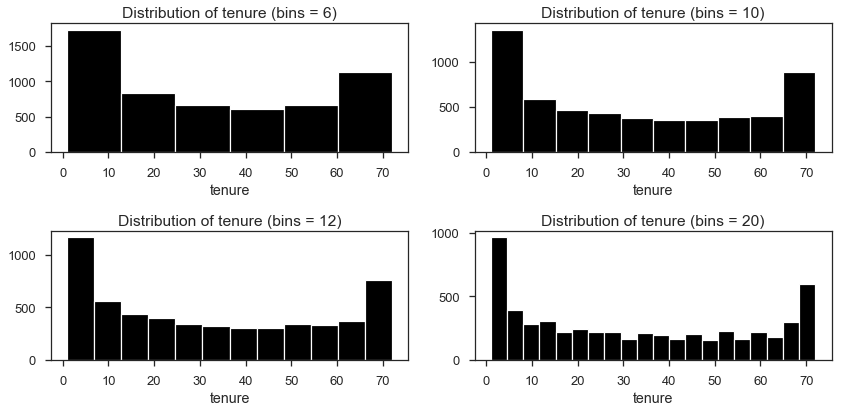

In [9]:
for i, bins in enumerate([6, 10, 12, 20]):
    plot_position = 220+i+1
    plt.subplot(plot_position)
    plot_histogram(data_df=X_train, 
                   feature_label='tenure',
                   nb_bins=bins)
    
plt.tight_layout()

As we vary the bins from 6 - 20, we see that the distribution seems to evolve from a slighly unbalanced one to a bimodal one. Different interpretations for a parameter choice usually made by default is not a good solution.

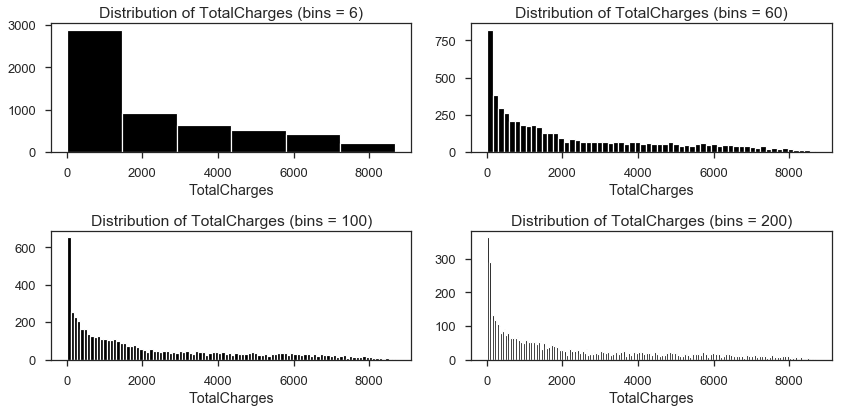

In [10]:
for i, bins in enumerate([6, 60, 100, 200]):
    plot_position = 220+i+1
    plt.subplot(plot_position)

    plot_histogram(data_df=X_train,
                   feature_label='TotalCharges', 
                   nb_bins=bins)
    
plt.tight_layout()

The situation is a bit more dicey when it comes to features having heavy-tailed distributions. As we can see in this figure, the skew of the feature is more pronounced when we use 200 bins as compared to 6 bins.

In sum, avoid histograms to judge the distribution of features. If there is one thing to take away from this talk, it is to never plot histograms for feature distributions.


### CDF's solve this problem by taking key decisions away from the analyst



&nbsp; 
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;


$$F(x) = \dfrac{\text{# samples} \leq x }{n} $$


So, if histograms dont work, what should we use? My personal choice is to plot CDF's. 

A CDF is defined as: $$F(x) = \dfrac{\text{# samples} \leq x }{n} $$ 
where $n$ is the total sample size.

There are several advantages to using CDF's. First, CDF's provide great visual feedback not only on the distribution but also key segments of the data, e.g., quantiles. Second, it is very easy to judge skew by looking at the shape of the CDF. In fact, a CDF that looks like a good ROC curve is a badly skewed distribution. Let us look at some examples.

Here is a little function that puts together the scaffolding required.

In [12]:
def plot_cdf(data_df, feature_label):

    x = np.sort(data_df[feature_label])
    y = np.linspace(0, 1, len(x), endpoint=False)

    plt.plot(x, y, color='black')
    
    for q in [0.25, 0.5, 0.75]:
        plt.axvline(x=np.quantile(x, q),
                    alpha=0.8, 
                    linewidth=1.2)

        plt.axhline(y=q, 
                    alpha=0.8, 
                    linewidth=1.2)

    plt.xlabel(feature_label)
    plt.ylabel('F(x)')
    plt.title('CDF of ' + feature_label)

From the definition of $F(x)$, we see that for each value $x$, we need to figure out the number of samples in the data set that are less than or equal to this value. The obvious starting point is then to sort the data in ascending order. 

Then, we map this sorted data set to the interval $[0, 1]$ divided into subintervals equal to number of points in the data set. This takes care of the denominator in the definition.

To aid simple analysis, I also usually add the lines corresponding to the quantiles in the data set. This is achieved by drawing the corresponding horizontal and vertical lines using the data.

### Let's now plot skewed and non-skewed cumulative distributions

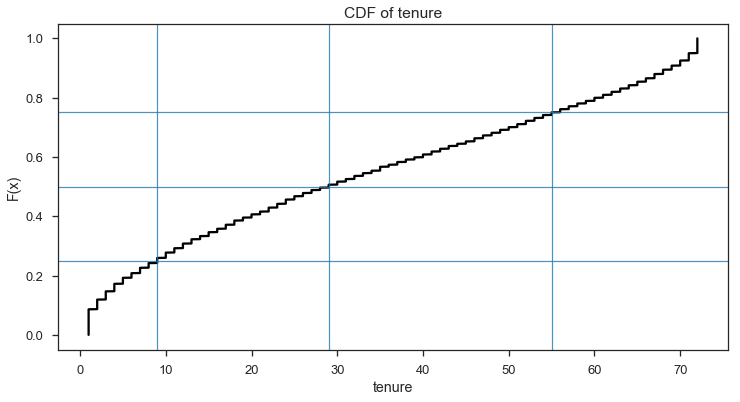

In [13]:
# Non-skewed distribution

plot_cdf(data_df=X_train, feature_label='tenure')

With experience, one comes to relate joy with seeing such plots. It has a characteristic swirl about half-way through that would make a normal distribution jump for joy. The quantile lines are reasonably far apart and not hunched together. These are indications of non-skew.

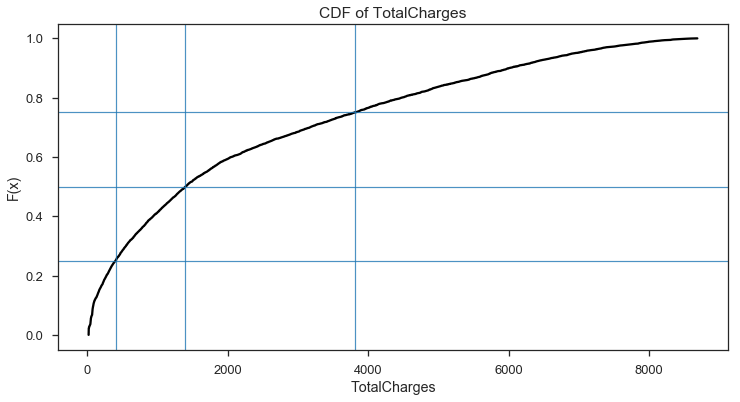

In [14]:
# Skewed distribution

plot_cdf(data_df=X_train, feature_label='TotalCharges')

This plot indicates the presence of skew. The quantile lines are hunched together (indicating that most data is concentrated in a narrow range). The long tail is visible as the flattened line beyond the $q = .75$ line. There are no joyful swirls in this one. A good ROC curve is a bad CDF.

### We can turbo charge the CDF by overlaying a normal distribution

Going, beyond the simple CDF plot, we can also get a sense of how far the feature distribution is from a normal distribution, by plotting both on the same plot. Normality is a good-to-have condition especially if one is looking to do linear models at a later stage.

Here is a helper function that superimposes a normal CDF on the data CDF

In [15]:
def plot_cdf_and_normal(data_df, feature_label):
    
    x = np.sort(data_df[feature_label])
    
    y = np.linspace(0, 1, len(x), endpoint=False)
    y_norm = ss.norm.cdf(x, np.mean(x), np.std(x))

    plt.plot(x, y, label='data')
    plt.plot(x, y_norm, label='normal distribution')
    
    plt.xlabel(feature_label)
    plt.legend()

We only add one more line to the plot earlier. We call the `cdf` function from the `scipy.stats.norm` module and pass in the mean and standard deviation of the data to initialize it. So, this function now plots the empirical distribution and the normal distribution with same mean and standard deviation.

### Lets plot the skewed cumulative distribution... again

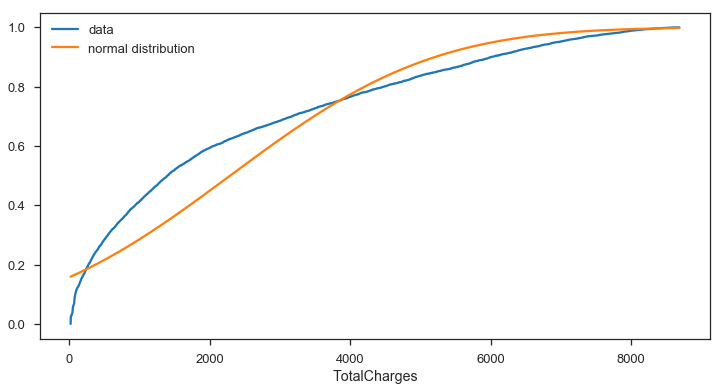

In [16]:
plot_cdf_and_normal(data_df=X_train,
                    feature_label='TotalCharges')

As we can see, the shapes are quite different. The twirl is missing.

### What to do when the features have a skewed distribution?



Call the superstars Yeo - Johnson

$$ y_{i}^{(\lambda)} = \begin{cases} ((y_i+1)^{\lambda} - 1)/\lambda, &\lambda \neq 0, y_i \geq 0 \\ log(y_i+1), &\lambda = 0, y_i \geq 0 \\ -((-y_i+1)^{2-\lambda} - 1)/(2-\lambda), &\lambda \neq 2, y_i < 0 \\ -log(-y_i+1), &\lambda = 2, y_i < 0  \end{cases} $$

How did Yeo - Johnson come up with such a complex transformation?!

In [17]:
def _yeo_johnson_optimize(self, x):
        """Find and return optimal lambda parameter of the Yeo-Johnson
        transform by MLE, for observed data x.
        Like for Box-Cox, MLE is done via the brent optimizer.
        """

        def _neg_log_likelihood(lmbda):
            """Return the negative log likelihood of the observed data x as a
            function of lambda."""
            x_trans = self._yeo_johnson_transform(x, lmbda)
            n_samples = x.shape[0]

            # Estimated mean and variance of the normal distribution
            est_mean = x_trans.sum() / n_samples
            est_var = np.power(x_trans - est_mean, 2).sum() / n_samples

            loglike = -n_samples / 2 * np.log(est_var)
            loglike += (lmbda - 1) * (np.sign(x) * np.log(np.abs(x) + 1)).sum()

            return -loglike

        # the computation of lambda is influenced by NaNs so we need to
        # get rid of them
        x = x[~np.isnan(x)]
        # choosing bracket -2, 2 like for boxcox
        return optimize.brent(_neg_log_likelihood, brack=(-2, 2))

In [18]:
# Apply Yeo - Johnson transformation using the PowerTransformer class in scikit

yj_pt = PowerTransformer(method='yeo-johnson')

X_train['TotalCharges_YJ'] = yj_pt.fit_transform(X_train['TotalCharges'].values.reshape(-1,1))


Lets see how things work out...

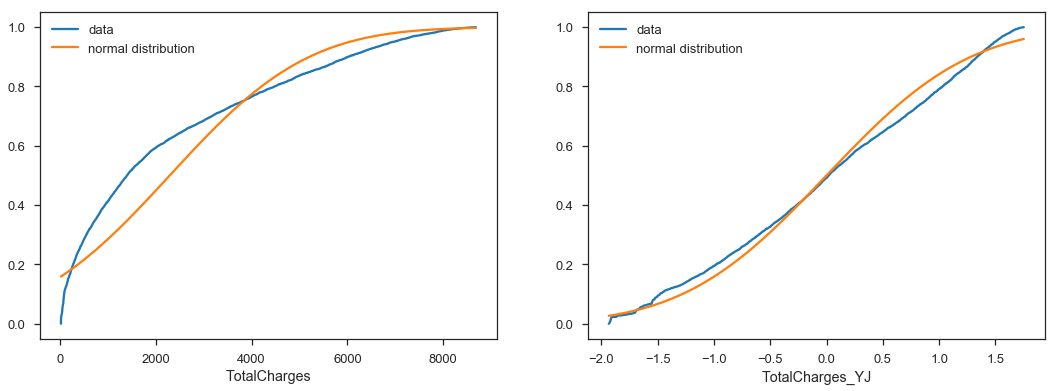

In [19]:
plt.figure(figsize=(18, 6))

plt.subplot(121)
plot_cdf_and_normal(data_df=X_train, feature_label='TotalCharges')


plt.subplot(122)
plot_cdf_and_normal(data_df=X_train, feature_label='TotalCharges_YJ')

Clearly, the transform makes a huge difference. Yeo - Johnson is really good at handling all kinds of numeric data and stabilizing the variance.

# Problem 2

<img src=figures/missing.jpg width="900">

Missing data is the peskiest of the pesky problems there are in this world. Most times, the solution to handling missing data is 'it depends'. That is not ideal at all. 

However, we need to start with a diagnosis of the gravity of the situation.

*'The most important aspect of a statistical analysis is not what you do with the data, it’s what data you use.'* - Andrew Gelman (several times)

First step is to see how deep the rabbit hole is...

In [20]:
def compute_missing_value_counts(data_df):
    
    counts = data_df.isnull().sum().sort_values(ascending=False)
    
    return counts[counts != 0]

Call the `isnull` function from pandas to generate a boolean mask and sum it by column. Then arrange the counts in descending order to identify the worst offenders and return the non-zero values in this list.

In [21]:
def compute_missing_value_perc(data_df):
    
    counts = data_df.isnull().sum().sort_values(ascending=False)
    
    non_zero_counts = counts[counts != 0]
    
    n_samples = data_df.shape[0]
    
    return non_zero_counts * 100/n_samples

In [22]:
def cols_with_missings(data_df):

    return [col for col in data_df.columns if data_df[col].isnull().any()]

Always ask the data source - how did you capture missing values?

In [23]:
churn_raw_df = pd.read_excel('data/WA_Fn-UseC_-Telco-Customer-Churn.xlsx', 
                             na_values=' ')

In [24]:
compute_missing_value_counts(churn_raw_df)

TotalCharges    11
dtype: int64

In [25]:
compute_missing_value_perc(churn_raw_df)

TotalCharges    0.156183
dtype: float64

In [26]:
cols_with_missings(churn_raw_df)

['TotalCharges']

Our custom functions do the diagnosis on the data set and return the number of missing values per column, percentage of missing values per column and the columns with missing values. In this example, the number is not very high, and we would be okay with any imputation strategy.

Lets turn to a little more complicated problem.

Lets make the problem a bit more complicated

In [27]:
properties_raw_df = pd.read_csv('data/big/properties_2016.csv')

In [28]:
cols_with_missings(properties_raw_df)[0:5] # show only first five in the list

['airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt']

There are too many features with missing values, so we look at only the top 5

In [29]:
compute_missing_value_perc(properties_raw_df)[0:5] # show 5 worst offenders

storytypeid                 99.945599
basementsqft                99.945465
yardbuildingsqft26          99.911330
fireplaceflag               99.827048
architecturalstyletypeid    99.796966
dtype: float64

This is a bad data set. Some columns have every thing missing. Unfortunately this is a common feature. If you can avoiding imputation is a good thing. If you can't, it is important to understand the nature of missing values in your data, i.e., are they randomly missing or is there a pattern. 

At a descriptive level, one can do one thing to quickly check. There is a nice package `missingno` that can produce a heatmap indicating the nullity correlations between the features with missing values. 

Snippet from the `heatmap` function in the `missingno` package

Create and mask the correlation matrix. Call the heatmap from seaborn.

----

```python

corr_mat = df.isnull().corr()

if labels:
    sns.heatmap(corr_mat, mask=mask, cmap=cmap, ax=ax0, cbar=False,
                annot=True, annot_kws={'size': fontsize - 2})
else:
    sns.heatmap(corr_mat, mask=mask, cmap=cmap, ax=ax0, cbar=False)
    
```

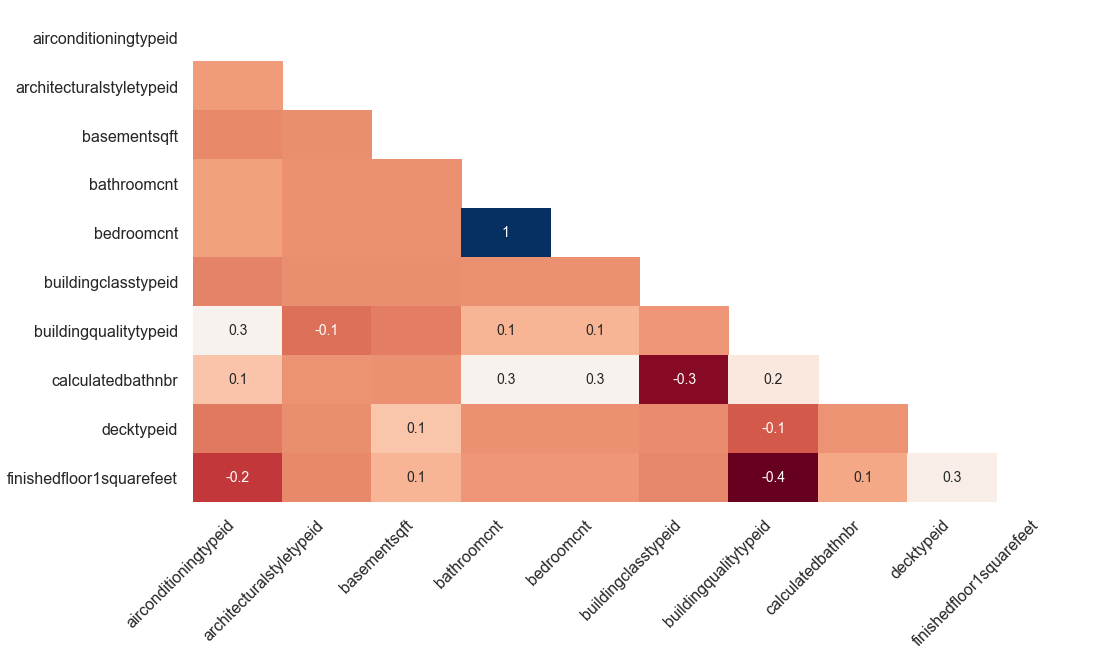

In [30]:
first_ten_missing_columns = cols_with_missings(properties_raw_df)[0:10]

missingno.heatmap(properties_raw_df[first_ten_missing_columns], figsize=(16,9))

The heat map above indicates which pairs of features are missing values together. Nullity correlation close to zero is not displayed. Positive nullity correlation indicates that when the first feature is missing, the second is also missing. Negative nullity correlation indicates that when the first feature is missing, the second is not.

## What to do with missing data?

Three common strategies

- Drop if okay
- Impute if not okay
- Add flag variable for missing values

Once we diagnose the depth of the missing value problem we have, it is time to be honest and ask if the data collection effort needs to be repeated. If it cannot, usually a threshold is fixed for missing values beyond which the aberrant features are dropped. Some sort of an imputation strategy, e.g., mean or median or mode, is then used to impute missing values.

However, there is one thing that is most important to do when we go ahead with imputation strategies. Add in a flag variable to indicate columns that had missing values and incorporate them as an additional feature. When you do this, systematic variations in missing values are captured in the modeling.

### Add flag variable when missing

In [31]:
def add_variable_for_missings(data_df):
    
    df = data_df.copy()
    
    for col in df.columns:
        df[col+'_missing'] = df[col].isnull()
        
    return df

In this function, we add in an additional feature that loops over the values in feature and returns a boolean mask indicating missing values

In [32]:
properties_missing_cols_df = add_variable_for_missings(properties_raw_df)

We can check if the columns were added based on missing values.

In [33]:
properties_raw_df.columns[-10:-1]

Index(['numberofstories', 'fireplaceflag', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'taxdelinquencyflag', 'taxdelinquencyyear'],
      dtype='object')

In [34]:
cols_with_missings(properties_raw_df)[-10:-1]

['numberofstories',
 'fireplaceflag',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'taxamount',
 'taxdelinquencyflag',
 'taxdelinquencyyear']

In [35]:
properties_missing_cols_df.columns[-10:-1]

Index(['numberofstories_missing', 'fireplaceflag_missing',
       'structuretaxvaluedollarcnt_missing', 'taxvaluedollarcnt_missing',
       'assessmentyear_missing', 'landtaxvaluedollarcnt_missing',
       'taxamount_missing', 'taxdelinquencyflag_missing',
       'taxdelinquencyyear_missing'],
      dtype='object')

# Problem 3

<img src=figures/correlations.jpg width="900">

## Correlations can be helpful in sense checking models

### (here we are concerned with correlation between features and target; not collinearity)

Moving the correlation story forward, we can use correlation as a valueable tool to guide our intuition on important features. Typical approaches to model building bank on a sequential build up of features. Also, the importance of features is an off shoot of tree based methods. 

We can however, directly compute correlation between the features and target to assess which features are important.

Here is a function that computes the correlation between the target and features

In [36]:
def compute_correlations(X_train_df, y_train_df, label_col_str):
    '''
    Compute correlations between all features, select the column corresponding 
    to the label, sort values in descending order and drop the entry for the 
    label (correlation with itself)

    '''
    data_df = pd.concat([X_train, y_train_df], axis=1)
    
    correlations_with_target = data_df.corr()[label_col_str].sort_values(ascending=False)[1:]
    
    corr_df = correlations_with_target.to_frame()
    
    corr_df.index.name = 'feature'
    corr_df.reset_index(inplace=True)
    
    return corr_df

In this function, we assume that the data has been separated into train and test. This is important since we do not want any intuition on the test data to inflitrate the modeling process.

First, we glue the features data and the label data (converted into a data frame).

Then, we compute the correlations between all the columns in the data frame.

Then, we pull the column corresponding to the target label and sort it in descending order.

Then, we take out the correlation of the target with itself (first entry) and convert the result to a data frame.

Finally, we set the column names to 'feature' and the label of the target.

In [37]:
def plot_correlations(correlation_df, feature_str, label_str):
    
    g = sns.PairGrid(correlation_df, x_vars=label_str, y_vars=feature_str,
                     size=6, aspect=1.1)
    
    g.map(sns.stripplot, palette="viridis",
          size=6, orient='h', linewidth=1, edgecolor="white")
    
    plt.axvline(x=0, color='gray', alpha=0.8, linewidth=1.2)
    plt.axvline(x=.2, color='red', alpha=0.8, linewidth=1.2)
    plt.axvline(x=-.2, color='red', alpha=0.8, linewidth=1.2)

`matplotlib` is not very great at handling categorical features. Thank you to `seaborn`. 

The first step is to set up a grid with pairs of feature and correlation with target. The next step is to map this object to the `stripplot` function that is like a scatter plot that can handle categorical data.

I usually like to annotate this plot with lines to indicate features that are highly correlated with the target (I choose .2)

Now, lets run these through some dat aot check how things look.

Lets run these through some data...

In [38]:
bank_raw_df = pd.read_csv('data/bank-full.csv', delimiter=';')

bank_features = bank_raw_df.drop(columns=['y'])
bank_features_dummified = pd.get_dummies(bank_features, dummy_na=False)

bank_labels = bank_raw_df['y']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(bank_features_dummified,
                                                    bank_labels, 
                                                    test_size=0.2, 
                                                    random_state=20130810)

y_train_df = pd.DataFrame(y_train.apply(lambda x: int(x == 'yes')), 
                          columns=['y'])

In [40]:
corr_df = compute_correlations(X_train, y_train_df, 'y')

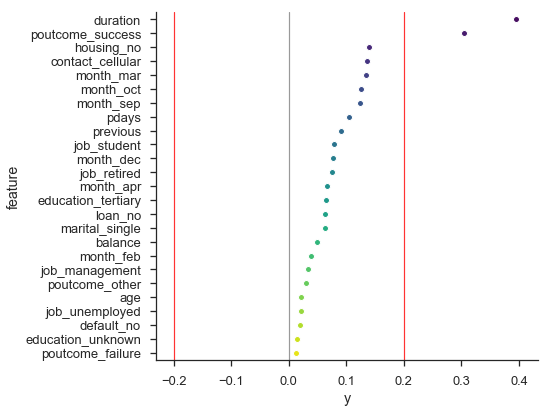

In [41]:
plot_correlations(corr_df.head(25), feature_str='feature', label_str='y')

There are far too many features to plot them in a single plot. Let us first look at the top 25 features. We can see that two of the features are very strongly correlated with the target. The rest are resting around 0 correlation.

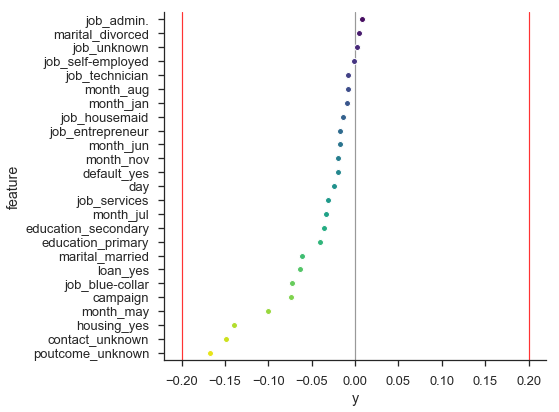

In [42]:
plot_correlations(corr_df.tail(25), feature_str='feature', label_str='y')

The situation is even worse for negatively correlated features. No strong correlations here.

We seem to have a set of weakly predictive features. Tree based methods would do well on this data set.

![thank you](figures/thanks.jpg)